# 6-Machine Learning (QBoost) with Quantum Annealing

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/OpenJij/OpenJijTutorial/blob/master/source/en/006-Machine_Learning_by_QA.ipynb)

In this section, we describe an aplication of machine lerning (ML) with quantum annealing (QA) optimization.

In the first, we show app;ication for clustering task using JijModeling and OpenJij.  
In the seconde, we execute an ensamble study called QBoost with PyQUBO and D-Wave sampler.

## Clustering

Clustering is the task of deviding given set of data into $n$ clusters ($n$ is our input). For the sake of simplicity, let us consider the number of cluster $n$ is 2 in this time.

### Clustering Hamiltonian
We demonstrate clustering by minimizing the following Hamiltonians.

$$
H = - \sum_{i, j} \frac{1}{2}d_{i,j} (1 - \sigma _i \sigma_j)
$$

Where $i, j$ is sample No., $d_{i, j}$ is a distance between $i$ and $j$, $\sigma_i=\{-1,1\}$ is spin variable that indicates whether $i$ belong to one of the two clusters.

Each term of this Hamiltonian sum behaves as follows.

- 0 for $\sigma_i  = \sigma_j $
- $d_{i,j}$ for $\sigma_i  \neq \sigma_j $  

Note that minus of R.H.S., Hamiltonian means the problem is "Choosing pairs of $\{\sigma _1, \sigma _2 \ldots \}$ that maximizes the distance between the samples of different classes".


### Importing the required libraries

We import several libraries for clustring.

In [1]:
# import libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix

import openjij as oj
import jijmodeling as jm
from jijmodeling.transpiler.pyqubo.to_pyqubo import to_pyqubo

### Clustering with JijModeling and OpenJij

At first, we formulate the mathmatical model in JijModeling. We cannot use spin variable in Jijmodeling, so we change spin variable $\sigma_i$ to binary variable $x_i$ by using the relationship $\sigma_i = 2x_i - 1$.

In [2]:
problem = jm.Problem("clustering")
d = jm.Placeholder("d", dim=2)
N = d.shape[0]
x = jm.Binary("x", shape=(N))
i = jm.Element("i", (0, N))
j = jm.Element("j", (0, N))
problem += (
    -1 / 2 * jm.Sum([i, j], d[i, j] * (1 - (2 * x[i] - 1) * (2 * x[j] - 1)))
)
problem

### Make artificial data

Next, we create instance data for the clustering problem.

In this case, let us generate linearly separable data in a two-dimensional plane artificially. Our clustering algortihm is unsupervised learning algorithm, so we do not need to prepare answer data.

In [3]:
data = []
label = []
N = 100
for i in range(N):
    # generate 0 to 1 random number
    p = np.random.uniform(0, 1)
    # set class 1 when certain condition are met, and -1 when it are not met
    cls = 1 if p > 0.5 else -1
    # create random numbers following a normal distribution
    data.append(np.random.normal(0, 0.5, 2) + np.array([cls, cls]))
    label.append(cls)
# formatted as a DataFrame
df1 = pd.DataFrame(data, columns=["x", "y"], index=range(len(data)))
df1["label"] = label

Let us see the data of the clustering problem.

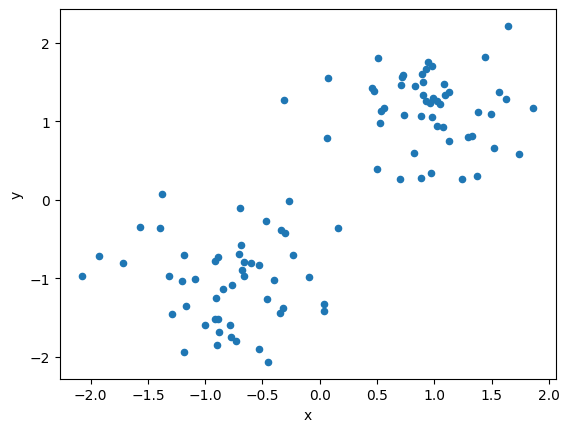

In [4]:
# visualize dataset
df1.plot(kind="scatter", x="x", y="y")
plt.show()

In [5]:
instance_data = {"d": distance_matrix(df1, df1)}

### Colsving the clustering problem by using OpenJij
We create mathmatical model and instance data, so let us solve the clustering problem by using openjij.

In [6]:
pyq_obj, pyq_cache = to_pyqubo(problem, instance_data, {})
qubo, constant = pyq_obj.compile().to_qubo()
sampler = oj.SASampler()
response = sampler.sample_qubo(qubo)
result = pyq_cache.decode(response)

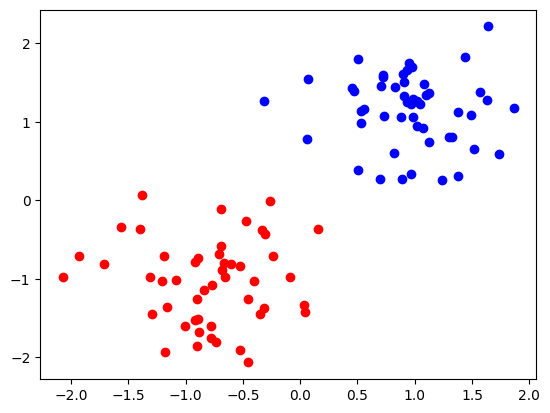

In [7]:
for idx in range(0, N):
    if idx in result.record.solution["x"][0][0][0]:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="b")
    else:
        plt.scatter(df1.loc[idx]["x"], df1.loc[idx]["y"], color="r")

We can see the data is clearly sperated by blue and red class.

## QBoost

QBoost is a one of the ensamble learning using QA. Ensamble learning involves preparing a number of weak predictors and combining the results of each of these predictors to obtain the final prediction result.

QBoost uses QA to optimize the best combination of learners for a given training data. We handle classification problem in this time.

We define that the set of $D$ training data are $\{\vec x^{(d)}\}(d=1, ..., D)$, corresponding label are $\{y^{(d)}\}(d=1, ..., D), y^{(d)}\in \{-1, 1\}$ and the (function) set of $N$ weak learner is $\{C_i\}(i=1, ..., N)$. For some data $\vec x^{(d)}$, $C_i(\vec x^{(d)})\in \{-1, 1\}$. 

Based on the definitions above, the classification labels are as follows.

$${\rm sgn}\left( \sum_{i=1}^{N} w_i C_i({\vec x}^{(d)})\right)$$

Where $w_i\in\{0, 1\} (i=1, ..., N)$, is a weight of each predictor (bool value to adopt or not adopt the predictor for the final prediction).QBoost optimizes the combination of $w_i$ so that prediction matches the training data while erasing the number of weak learners.

Hamiltonian in this problem is as follows.

$$H(\vec w) = \sum_{d=1}^{D} \left( \frac{1}{N}\sum_{i=1}^{N} w_i C_i(\vec x^{(d)})-y^{(d)} \right)^2 + \lambda \sum _i^N w_i$$

The first term represents the difference between weak classifier and the correct label. The second term represents a degree of the number of weak classifier to be employed in the final classifier. $\lambda$ is the regularization parameter that adjust how much the number of weak classifiers affects the total Hamiltonian.

We optimize this Hamiltonian by recognizing the first term as a cost (objective function) and the second term as a constraint.Minimizing with QA allows us to obtain a combination of weak classifiers that best fits the training data.

### Preparation of dataset

Let us try QBoost. We use the cancer identification dataset from scikit-learn for training data. For simplicity, we will only use two character types for training: "0" and "1".

In [11]:
# import libraries
import pandas as pd
from scipy import stats
from sklearn import datasets
from sklearn import metrics

In [68]:
# load data
cancerdata = datasets.load_breast_cancer()
# set the number of training data & test data
num_train = 450

In this time, we consider that feature of noise exists.

In [69]:
data_noisy = np.concatenate(
    (cancerdata.data, np.random.rand(cancerdata.data.shape[0], 30)), axis=1
)
print(data_noisy.shape)

(569, 60)


In [70]:
# convert from label {0, 1} to {-1, 1}
labels = (cancerdata.target - 0.5) * 2

In [71]:
# divide dataset to training and test
X_train = data_noisy[:num_train, :]
X_test = data_noisy[num_train:, :]
y_train = labels[:num_train]
y_test = labels[num_train:]

In [72]:
# from the result of weak learnor
def aggre_mean(Y_list):
    return ((np.mean(Y_list, axis=0) > 0) - 0.5) * 2

### Creating Set of Weak Learner

We make weak learner with scikit-learn. In this time, we choose decision stump. Desision stump is a single-layer decision tree. As it will be used as a weak classifier, the features to be used for segmentation are selected randomly (it's a good understanding that we execute single-layer of random forest).

In [73]:
# import required libraries
from sklearn.tree import DecisionTreeClassifier as DTC

# set the number of weak classifier
num_clf = 32
# set the number of ensembles to be taken out for one sample in bootstrap sampling
sample_train = 40
# set model
models = [DTC(splitter="random", max_depth=1) for i in range(num_clf)]
for model in models:
    # extract randomly
    train_idx = np.random.choice(np.arange(X_train.shape[0]), sample_train)
    # make decision tree with variables
    model.fit(X=X_train[train_idx], y=y_train[train_idx])
y_pred_list_train = []
for model in models:
    # execute prediction with model
    y_pred_list_train.append(model.predict(X_train))
y_pred_list_train = np.asanyarray(y_pred_list_train)
y_pred_train = np.sign(y_pred_list_train)

We look accuracy of all weak learner as the final classifier. Henceforth, we refer to this combination as baseline.

In [74]:
y_pred_list_test = []
for model in models:
    # execute with test data
    y_pred_list_test.append(model.predict(X_test))

y_pred_list_test = np.array(y_pred_list_test)
y_pred_test = np.sign(np.sum(y_pred_list_test, axis=0))
# compute score of prediction accuracy
acc_test_base = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_test)
print(acc_test_base)

0.9411764705882353


### Execute QBoost with OpenJij

Let us creater QBoost model.

In [84]:
# set class of QBoost
class QBoost:
    def __init__(self, y_train, ys_pred):
        self.instance_data = {"y": y_train, "C": ys_pred}
        self.qboost_Hamiltonian()
        self.pyq_obj, self.pyq_cache = to_pyqubo(
            self.problem, self.instance_data, {}
        )

    def qboost_Hamiltonian(self):
        problem = jm.Problem("QBoost")
        C = jm.Placeholder("C", dim=2)
        y = jm.Placeholder("y", dim=1)
        N = C.shape[0].set_latex("N")
        D = C.shape[1].set_latex("D")
        w = jm.Binary("w", shape=(N))
        i = jm.Element("i", (0, N))
        d = jm.Element("d", (0, D))
        obj = jm.Sum(
            d,
            (1 / N * jm.Sum(i, w[i] * C[i, d]) - y[d])
            * (1 / N * jm.Sum(i, w[i] * C[i, d]) - y[d]),
        )
        constraint = jm.Constraint("constraint", jm.Sum(i, w[i]))
        problem += obj
        problem += constraint
        self.problem = problem

    def sampling(self, qubo, **kwargs):
        sampler = oj.SASampler(**kwargs)
        response = sampler.sample_qubo(qubo)
        return response

    def decode(self, response):
        return self.pyq_cache.decode(response)

    # set function for converting to QUBO
    def to_qubo(self, norm_param=1):
        # set value of hyperparameter
        self.multiplier = {"constraint": norm_param}
        model = self.pyq_obj.compile()
        return model.to_qubo(feed_dict=self.multiplier)

In [85]:
qboost = QBoost(y_train=y_train, ys_pred=y_pred_list_train)
qboost.problem

In [86]:
# make QUBO with lambda=3
qubo = qboost.to_qubo(1)[0]
response = qboost.sampling(qubo, num_reads=100, num_sweeps=10)
result = qboost.decode(response)

Let us check the accuracy in the training/validation data when using a combination of weak classifiers obtained by D-Wave.

In [92]:
accs_train_Dwaves = []
accs_test_Dwaves = []

for solution in result.record.solution["w"]:
    idx_clf_DWave = solution[0][0]
    y_pred_train_DWave = np.sign(
        np.sum(y_pred_list_train[idx_clf_DWave, :], axis=0)
    )
    y_pred_test_DWave = np.sign(
        np.sum(y_pred_list_test[idx_clf_DWave, :], axis=0)
    )
    acc_train_DWave = metrics.accuracy_score(
        y_true=y_train, y_pred=y_pred_train_DWave
    )
    acc_test_DWave = metrics.accuracy_score(
        y_true=y_test, y_pred=y_pred_test_DWave
    )
    accs_train_Dwaves.append(acc_train_DWave)
    accs_test_Dwaves.append(acc_test_DWave)

In [93]:
energies = result.evaluation.energy

We make a graph with energy on the horizontal axis and accuracy on the vertical axis.

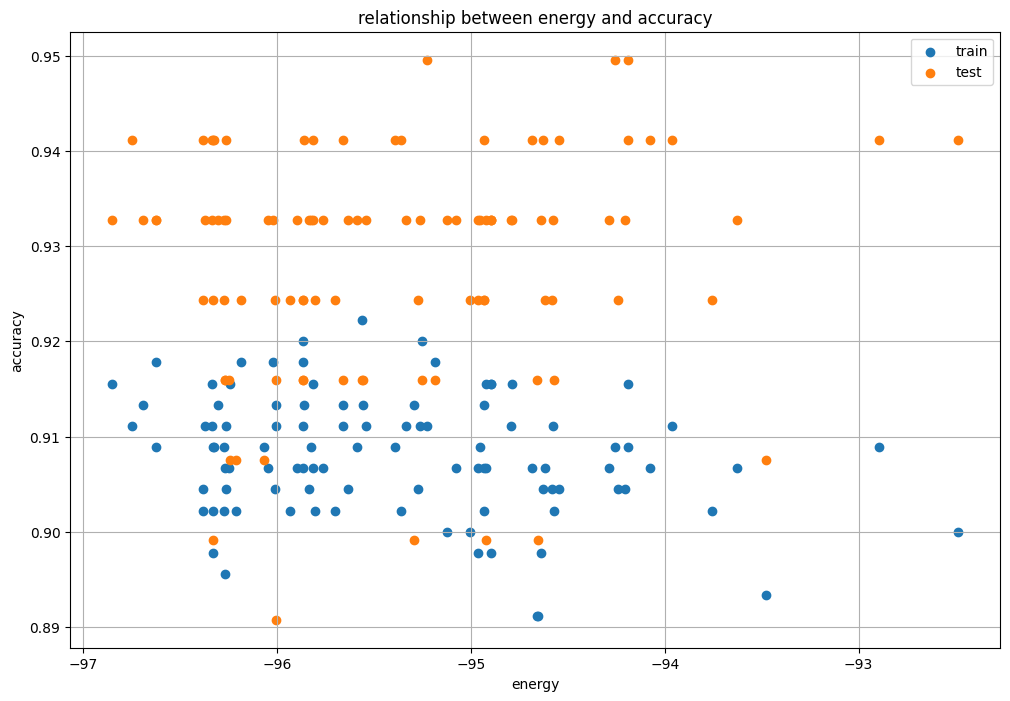

In [94]:
plt.figure(figsize=(12, 8))
plt.scatter(energies, accs_train_Dwaves, label="train")
plt.scatter(energies, accs_test_Dwaves, label="test")
plt.xlabel("energy")
plt.ylabel("accuracy")
plt.title("relationship between energy and accuracy")
plt.grid()
plt.legend()
plt.show()

In [95]:
print("base accuracy is {}".format(acc_test_base))
print("max accuracy of QBoost is {}".format(max(accs_test_Dwaves)))
print(
    "average accuracy of QBoost is {}".format(
        np.mean(np.asarray(accs_test_Dwaves))
    )
)

base accuracy is 0.9411764705882353
max accuracy of QBoost is 0.9495798319327731
average accuracy of QBoost is 0.9284033613445378
